In [21]:
from injector_surrogate import *

<a id="init"></a>
# Initial Info

### Loading basic model info
todo - put into config file

In [24]:
PATH = ''
screen ='OTR2'
NAME = 'v3b_cnsga_'

In [25]:
with open(PATH+NAME+screen+'_list_dict.json') as json_file:
    json_names = json.load(json_file)
    
#inputs and outputs in raw data
output_names=json_names['out_'+screen+'_vars']
input_names = json_names['input_vars']


In [26]:
#load model info
model_info = json.load(open('./model_info.json'))

#inputs and outputs model is  trained on
model_in_list = model_info['model_in_list']
model_out_list = model_info['model_out_list']

#dictionary of location of variables in array
loc_in = model_info['loc_in']
loc_out = model_info['loc_out']

#inputs and outputs model is  trained on
input_mins = model_info['train_input_mins']
input_maxs = model_info['train_input_maxs']

### Conversion between sim and machine

Explanation on model inputs and how they relate to PVs:
https://github.com/slaclab/lcls-cu-inj-surrogate/blob/master/pv_mapping/cu_inj_impact.csv

In [27]:
pv_info = json.load(open('./pvinfo.json'))

In [28]:
pv_info.keys()

dict_keys(['pv_to_sim_factor', 'pv_unit', 'pv_name_to_sim_name', 'sim_name_to_pv_name', 'sim_to_pv_factor'])

In [29]:
pv_to_sim_factor = pv_info['pv_to_sim_factor']
sim_to_pv_factor = pv_info['sim_to_pv_factor']
pv_unit = pv_info['pv_unit']
pv_name_to_sim_name = pv_info['pv_name_to_sim_name']
sim_name_to_pv_name = pv_info['sim_name_to_pv_name']

In [30]:
model_in_list

['distgen:r_dist:sigma_xy:value',
 'distgen:t_dist:length:value',
 'distgen:total_charge:value',
 'SOL1:solenoid_field_scale',
 'CQ01:b1_gradient',
 'SQ01:b1_gradient',
 'L0A_scale:voltage',
 'L0A_phase:dtheta0_deg',
 'L0B_scale:voltage',
 'L0B_phase:dtheta0_deg']

In [31]:
sim_name_to_pv_name 

{'distgen:r_dist:sigma_xy:value': 'IRIS:LR20:130:CONFG_SEL',
 'SOL1:solenoid_field_scale': 'SOLN:IN20:121:BDES',
 'CQ01:b1_gradient': 'QUAD:IN20:121:BDES',
 'SQ01:b1_gradient': 'QUAD:IN20:122:BDES',
 'L0A_phase:dtheta0_deg': 'ACCL:IN20:300:L0A_PDES',
 'L0B_phase:dtheta0_deg': 'ACCL:IN20:400:L0B_PDES',
 'L0A_scale:voltage': 'ACCL:IN20:300:L0A_ADES',
 'L0B_scale:voltage': 'ACCL:IN20:400:L0B_ADES',
 'QA01:b1_gradient': 'QUAD:IN20:361:BDES',
 'QA02:b1_gradient': 'QUAD:IN20:371:BDES',
 'QE01:b1_gradient': 'QUAD:IN20:425:BDES',
 'QE02:b1_gradient': 'QUAD:IN20:441:BDES',
 'QE03:b1_gradient': 'QUAD:IN20:511:BDES',
 'QE04:b1_gradient': 'QUAD:IN20:525:BDES',
 'distgen:t_dist:length:value': 'Pulse_length',
 'distgen:total_charge:value': 'Charge'}

### Load Model and Predict

In [32]:
Model = Surrogate_NN(model_in_list,
                 model_out_list,
                 input_mins,
                 input_maxs,
                 pv_name_to_sim_name,
                 pv_to_sim_factor,
                 sim_name_to_pv_name)


Model.load_saved_model()#'','model_OTR2_NA_rms_emit_tanh_2021-02-21T09:49:21-08:00')
Model.load_scaling()

/sdf/home/e/edelen/miniconda3/envs/ml_nersc/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Predict sim units

In [33]:
#sim units
X_true = np.load('x_raw_small.npy')
Y_true = np.load('y_raw_small.npy')

In [34]:
# make predictions in sim units
Y_pred = Model.pred_sim_units(X_true)

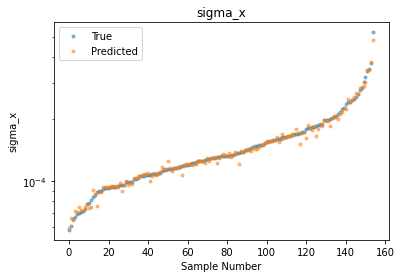

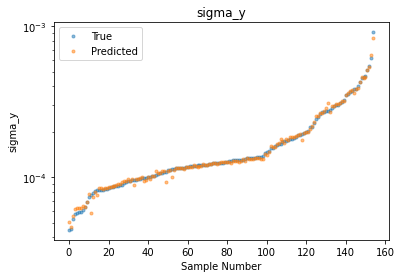

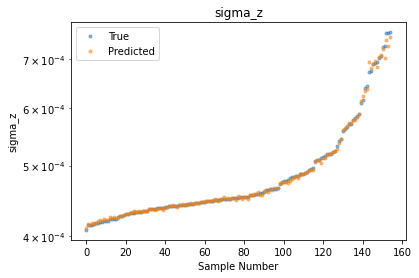

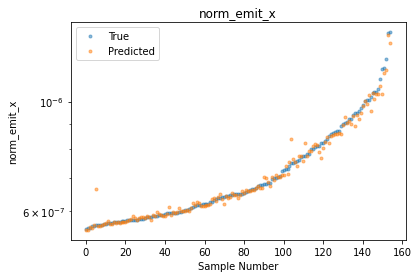

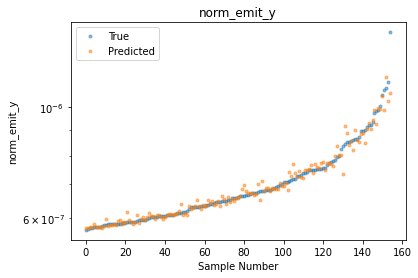

In [35]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(Model.model_out_list[i])
    plt.ylabel(Model.model_out_list[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted'])
    plt.show()

### Predict machine units

In [36]:
#Get some machine unit values by converting sim data
X_true_pv = sim_to_machine(np.asarray(X_true))

In [37]:
Y_pred_pv = Model.pred_machine_units(X_true_pv);

In [38]:
Y_pred_sim = Model.pred_sim_units(X_true);

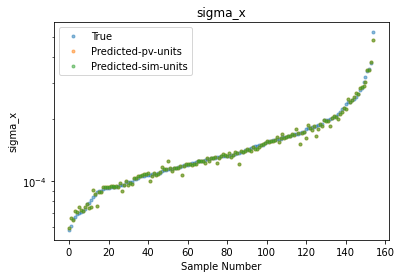

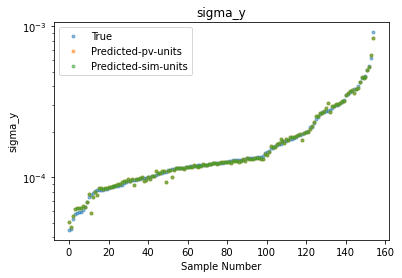

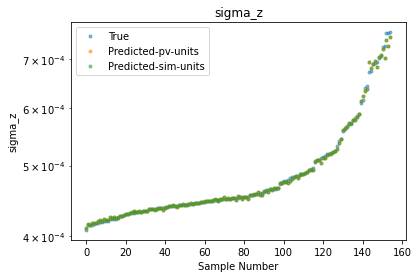

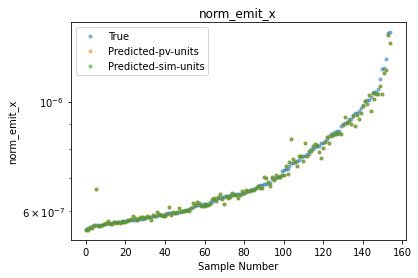

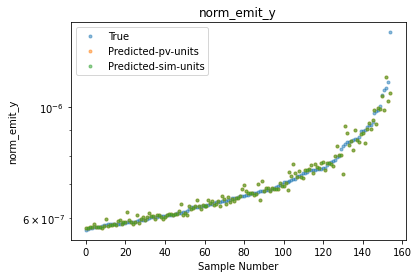

In [39]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred_pv[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred_sim[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(Model.model_out_list[i])
    plt.ylabel(Model.model_out_list[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted-pv-units','Predicted-sim-units'])
    plt.show()

<a id="BO"></a>
# Small BO Run

In [50]:
ref_point = [[4.23867825e-01,
                      3.06083484e+00,
                      2.50000000e+02,
                      2.45806452e-01,
                      7.13917676e-04,
                      3.27285211e-04,
                      5.80000000e+07,
                      -9.53597349e+00,
                      7.00000000e+07,
                        9.85566222e+00]]

ref_point = sim_to_machine(np.asarray(ref_point))

#nested_list
ref_point=[ref_point[0]]

In [51]:


opt_var_names = ['SOL1:solenoid_field_scale','SQ01:b1_gradient','CQ01:b1_gradient']
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(varx,vary,varz):

    #make input array of length model_in_list
    x_in = np.empty((1,len(Model.model_in_list)))

    #fill in reference point around whicch to optimize
    x_in[:,:] = np.asarray(ref_point)

    #set solenoid, SQ, CQ to values from optimization step
    x_in[:, Model.loc_in[opt_var_names[0]]] = varx
    x_in[:, Model.loc_in[opt_var_names[1]]] = vary
    x_in[:, Model.loc_in[opt_var_names[2]]] = varz

    # would want to change this to 
    y_out = Model.pred_sim_units(x_in) 
    print(y_out)

    return -1*objective(y_out)[0]


def objective(y_out):
    out1 = y_out[:,loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:,loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    
    return np.sqrt(out1*out2)


In [54]:
from bayes_opt import BayesianOptimization

pbounds = {'varx': (0.44, 0.55),
           'vary': (-0.02, 0.02),
           'varz': (-0.02, 0.02)}

optimizer = BayesianOptimization(
    f = evaluate,
    pbounds = pbounds,
    random_state = 1,
)

optimizer.maximize(
    init_points=10,
    n_iter=40,
)

|   iter    |  target   |   varx    |   vary    |   varz    |
-------------------------------------------------------------
[[2.9693992e-04 1.6553271e-04 4.7145222e-04 9.4704723e-07 1.2634083e-06]]
|  1        | -1.094e-0 |  0.4859   |  0.008813 | -0.02     |
[[1.1227604e-04 2.5596897e-04 4.6861119e-04 8.8930290e-07 1.1359494e-06]]
|  2        | -1.005e-0 |  0.4733   | -0.01413  | -0.01631  |
[[2.4537212e-04 5.1504601e-04 4.5500905e-04 9.3351326e-07 1.0427668e-06]]
|  3        | -9.866e-0 |  0.4605   | -0.006178 | -0.004129 |
[[5.0982850e-04 6.6587927e-05 4.7205962e-04 1.3067519e-06 1.1214986e-06]]
|  4        | -1.211e-0 |  0.4993   | -0.003232 |  0.007409 |
[[2.9452998e-04 4.8745537e-04 4.5960789e-04 7.5851614e-07 1.0951378e-06]]
|  5        | -9.114e-0 |  0.4625   |  0.01512  | -0.0189   |
[[4.2867448e-04 4.7319882e-05 4.7617420e-04 1.4784256e-06 1.5225029e-06]]
|  6        | -1.5e-06  |  0.5138   | -0.003308 |  0.002348 |
[[2.7096085e-04 6.1804318e-04 4.5433259e-04 1.1103139e-06 8.

In [55]:
SOL_opt = optimizer.max['params']['varx']
CQ_opt = optimizer.max['params']['vary']
SQ_opt = optimizer.max['params']['varz']
print('optimum (pv_units) ',SOL_opt, CQ_opt, SQ_opt)

opt_emit = -1*optimizer.max['target']
print('optimum geom emit ', opt_emit)

optimum (pv_units)  0.47790413817328165 -8.851912749994681e-05 0.00018995697875329523
optimum geom emit  5.695450226994581e-07
